In [4]:
from alpha_vantage.timeseries import TimeSeries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as se
se.set()

In [140]:
shorts = ['SQQQ','SPXU','SDOW','SRTY']
DOW = ['MMM','AXP','AAPL','BA',
       'CAT','CVX','CSCO','KO',
       'DIS','DOW','XOM','GS',
      'HD','IBM','INTC','JNJ',
      'JPM','MCD','MRK','MSFT',
      'PFE','PG','TRV','UTX',
      'UNH','VZ','V','WMT','WBA']

In [141]:
#prepare the data
def p_return(df):
    df_op = df["1. open"].values
    df_cl = df["4. close"].values
    p = ((df_op*(df_op-df_cl))/df_op)
    return p

v = []

startDate = '2020-02-01'
endDate = '2020-03-15'

strStocks = "shorts"
Stocks = shorts
buy=np.empty((len(Stocks),1))
sell=np.empty((len(Stocks),1))

i = 0 
for s in Stocks:
    fn = strStocks + "/" + s + ".csv"
    temp = pd.read_csv(fn,usecols=["date","1. open","4. close"]
                       ,engine='c',index_col=0)
    temp.index = pd.to_datetime(temp.index)
    temp=temp[(temp.index >= startDate) & (temp.index <= endDate )]
    v.append(p_return(
        temp)
            )
    buy[i]=temp["1. open"][0]
    sell[i]=temp["4. close"][-1]
    i+=1

In [142]:
#covariance matrix
sigma = np.cov(v)
sigma =  np.reshape(sigma,(len(Stocks),len(Stocks)))

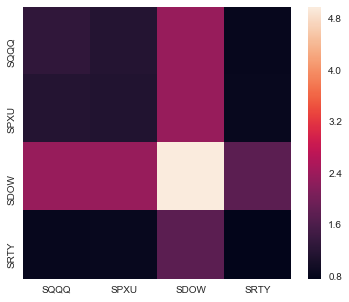

In [143]:
#covariance heat map
plt.figure(figsize=(6,5))
se.heatmap(sigma,xticklabels=Stocks,yticklabels=Stocks,)

#### Risk Parity - fixed point

In [161]:
#Fix point
#init weights to invers var
v = np.diag(sigma)
w = (1/v)/sum(1/v)
w = np.reshape(w, (len(w),1))

n=100000000
F_last = 1000

error = np.empty(n)
for i in range(1,n):
    
    w = (1/np.dot(sigma,w))/sum(1/np.dot(sigma,w))
    
    F = np.dot(np.dot(np.transpose(w),sigma),w)
    error[i]=(abs(F - F_last))
    
    
    c = (w * (np.dot(sigma,w)))
    c1 = c[0,0] * np.ones((len(c),1))
    l2 = np.linalg.norm(c1 - c)

    if(l2 < 0.00001):
        break
print("Iterations: %d \nRisk Per Weight: %.5f" %(i,c[0,0]))

Iterations: 4 
Risk Per Weight: 0.31885


In [162]:
R=sell/buy
R_total=np.dot(np.transpose(R),w)-1
var=np.dot(np.dot(np.transpose(w),sigma),w)[0,0] 
print("Min Var")
print("Var: %.4f \tReturn: %.4f"%(var, R_total))
print(30*"=")
print("%s %10s"%("Investment", "Weight"))
print(30*"=")

for i in range(len(Stocks)):
    print("%s: %15.4f" %(Stocks[i],w[i]))
print(30*"=")

Min Var
Var: 1.2754 	Return: 0.5324
Investment     Weight
SQQQ:          0.2590
SPXU:          0.2674
SDOW:          0.1286
SRTY:          0.3450


#### Comparing Risk Parity with MinVar

In [164]:
iota = np.ones(shape=(len(Stocks),1))
invSigma = np.linalg.inv(sigma)
#Calc Min-Var
num = np.dot(invSigma,iota)
de = np.dot(np.transpose(iota),num)
minVar = num/de

R_total=np.dot(np.transpose(R),minVar)-1
var = np.dot(np.dot(np.transpose(minVar),sigma),minVar)[0,0]

print("Min Var")
print("Var: %.4f \tReturn: %.8f"%(var, R_total))
print(30*"=")
print("%s %10s"%("Investment", "Weight"))
print(30*"=")
for i in range(len(Stocks)):
    print("%s: %15.4f" %(Stocks[i],minVar[i]))
print(30*"=")

Min Var
Var: 0.0598 	Return: 0.57732473
Investment     Weight
SQQQ:         -0.6106
SPXU:          2.5074
SDOW:         -0.8684
SRTY:         -0.0285
